# NCAA Starter - The simpler the better 

In this notebook I present a quite simple approach to the problem.

It is adapted from what I intended to submit last year. 
The main idea is that the simpler the model, the more robust. Complicated models don't necessarily outperform simpler ones on prediction competitons.
Hence I only use 12 simple features (in fact I could reduce this number down to 4) with a logistic regression.


This work (mostly) adapts to the women competition by replacing the `M` by a `W`. Only the ratings are missing.
Just uncomment/comment the corresponding lines, or browse through the notebook versions !

- Version 9 : NCAAW
- Version 7 : NCAAM

In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [2]:
# DATA_PATH = '../input/ncaam-march-mania-2021/'
DATA_PATH = '../input/mens-march-mania-2022\MDataFiles_Stage2/'
DATA_PATH_M = DATA_PATH

for filename in os.listdir(DATA_PATH):
    print(filename)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thruDay128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSampleSubmissionStage2.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeams.csv
MTeamSpellings.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [3]:
# df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
df_seeds = pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [4]:
# df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv")
df_season_results = pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv")
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [7]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [8]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [9]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [10]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [11]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [12]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

C:\Users\yizha\AppData\Local\Temp\ipykernel_10944\108246023.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


In [13]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [14]:
df_features_season.fillna(0, inplace=True)  

Compute features

In [15]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [16]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [17]:
# df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df_tourney_results = pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

The `DayNum` features can be improved by replacing it by the corresponding round.

In [18]:
def get_round(day):
#     round_dic = {134: 0, 135: 0, 136: 1, 137: 1, 138: 2, 139: 2, 143: 3, 144: 3, 145: 4, 146: 4, 152: 5, 154: 6}
    round_dic = {137: 0, 138: 0, 139: 1, 140: 1, 141: 2, 144: 3, 145: 3, 146: 4, 147: 4, 148: 4, 151:5, 153: 5, 155: 6} # probably wrong but I don't use it anyways
    try:
        return round_dic[day]
    except:
        print(f'Unknow day : {day}')
        return 0

In [19]:
df_tourney_results['Round'] = df_tourney_results['DayNum'].apply(get_round)

Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 152
Unknow day : 152
Unknow day : 154
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 143
Unknow day : 152
Unknow day : 152
Unknow day : 154
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 136
Unknow day : 1

In [20]:
df_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,1985,136,1116,63,1234,54,0
1,1985,136,1120,59,1345,58,0
2,1985,136,1207,68,1250,43,0
3,1985,136,1229,58,1425,55,0
4,1985,136,1242,49,1325,38,0


## Ratings
- Only for men...

### Massey Ordinals

> This file lists out rankings (e.g. #1, #2, #3, ..., #N) of teams going back to the 2002-2003 season, under a large number of different ranking system methodologies.
- Season - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs)
- RankingDayNum - First day that it is appropriate to use the rankings for predicting games. Use 133 for the tournament. 
- SystemName - this is the (usually) 3-letter abbreviation for each distinct ranking system.
- TeamID - this is the ID of the team being ranked, as described in MTeams.csv.
- OrdinalRank - this is the overall ranking of the team in the underlying system. Most systems from recent seasons provide a complete ranking from #1 through #351, but sometimes there are ties and sometimes only a smaller set of rankings is provided, as with the AP's top 25. This year and last year they will typically go up to #353 because two new teams were added to Division I last year.

In [22]:
df_massey = pd.read_csv(DATA_PATH_M + "MMasseyOrdinals_thruDay128.csv")
df_massey = df_massey[df_massey['RankingDayNum'] == 133].drop('RankingDayNum', axis=1).reset_index(drop=True) # use first day of the tournament

In [23]:
df_massey.tail()

,Season,SystemName,TeamID,OrdinalRank
309504,2021,WOB,1467,233
309505,2021,WOB,1468,176
309506,2021,WOB,1469,290
309507,2021,WOB,1470,256
309508,2021,WOB,1471,234


### Processing

- I keep only systems that are common to all the years.

In [24]:
# systems = []
# for year in range(2003, 2019):
#     r = df_massey[df_massey['Season'] == year]
#     systems.append(r['SystemName'].unique())
    
# all_systems = list(set(list(np.concatenate(systems))))

In [25]:
# common_systems = []  
# for system in all_systems:
#     common = True
#     for system_years in systems:
#         if system not in system_years:
#             common = False
#     if common:
#         common_systems.append(system)
        
# common_systems

In [26]:
# df_massey = df_massey[df_massey['SystemName'].isin(common_systems)].reset_index(drop=True)

# Feature Engineering

## Train data

In [27]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2003].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round
0,2003,134,1421,92,1411,84,0
1,2003,136,1112,80,1436,51,0
2,2003,136,1113,84,1272,71,0
3,2003,136,1141,79,1166,73,0
4,2003,136,1143,76,1301,74,0


- Each row corresponds to a match between `WTeamID` and `LTeamID`, which was won by `WTeamID`. 
- I only keep matches after 2003 since I don't have the ratings for the older ones.
- I start by aggregating features coresponding to each tem.

### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [28]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [29]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [30]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [31]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [32]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL
0,2003,134,1421,92,1411,84,0,16,16
1,2003,136,1112,80,1436,51,0,1,16
2,2003,136,1113,84,1272,71,0,10,7
3,2003,136,1141,79,1166,73,0,11,6
4,2003,136,1143,76,1301,74,0,8,9


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [33]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [34]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [35]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,2003,134,1421,92,1411,84,0,16,16,0.448276,-7.241379,0.600000,1.966667
1,2003,136,1112,80,1436,51,0,1,16,0.892857,14.964286,0.655172,4.655172
2,2003,136,1113,84,1272,71,0,10,7,0.620690,6.793103,0.793103,8.689655
3,2003,136,1141,79,1166,73,0,11,6,0.793103,6.103448,0.878788,14.909091
4,2003,136,1143,76,1301,74,0,8,9,0.724138,4.724138,0.600000,4.400000


### Ratings
- `OrdinalRankW` is the average Massey Ranking of the winning team
- `OrdinalRankL` is the average Massey Ranking of the  losing team

In [36]:
avg_ranking = df_massey.groupby(['Season', 'TeamID']).mean().reset_index()

In [37]:
# df = pd.merge(
#     df,
#     avg_ranking,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankW'})

In [38]:
# df = pd.merge(
#     df, 
#     avg_ranking, 
#     how='left', 
#     left_on=['Season', 'LTeamID'], 
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankL'})

In [39]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,Round,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,2003,134,1421,92,1411,84,0,16,16,0.448276,-7.241379,0.600000,1.966667
1,2003,136,1112,80,1436,51,0,1,16,0.892857,14.964286,0.655172,4.655172
2,2003,136,1113,84,1272,71,0,10,7,0.620690,6.793103,0.793103,8.689655
3,2003,136,1141,79,1166,73,0,11,6,0.793103,6.103448,0.878788,14.909091
4,2003,136,1143,76,1301,74,0,8,9,0.724138,4.724138,0.600000,4.400000


### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [40]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
        "SeedW": "SeedA", 
        "SeedL": "SeedB",
        'WinRatioW' : 'WinRatioA',
        'WinRatioL' : 'WinRatioB',
        'GapAvgW' : 'GapAvgA',
        'GapAvgL' : 'GapAvgB',
#         "OrdinalRankW": "OrdinalRankA",
#         "OrdinalRankL": "OrdinalRankB",
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
        "SeedW": "SeedB", 
        "SeedL": "SeedA",
        'GapAvgW' : 'GapAvgB',
        'GapAvgL' : 'GapAvgA',
        'WinRatioW' : 'WinRatioB',
        'WinRatioL' : 'WinRatioA',
#         "OrdinalRankW": "OrdinalRankB",
#         "OrdinalRankL": "OrdinalRankA",
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [41]:
df = add_loosing_matches(df)

C:\Users\yizha\AppData\Local\Temp\ipykernel_10944\1722625647.py:38: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat([win_df, lose_df], 0, sort=False)


### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [42]:
df['SeedDiff'] = df['SeedA'] - df['SeedB']
df['WinRatioDiff'] = df['WinRatioA'] - df['WinRatioB']
df['GapAvgDiff'] = df['GapAvgA'] - df['GapAvgB']
# df['OrdinalRankDiff'] = df['OrdinalRankA'] - df['OrdinalRankB']

In [43]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,Round,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,2003,134,1421,92,1411,84,0,16,16,0.448276,-7.241379,0.600000,1.966667,0,-0.151724,-9.208046
1,2003,136,1112,80,1436,51,0,1,16,0.892857,14.964286,0.655172,4.655172,-15,0.237685,10.309113
2,2003,136,1113,84,1272,71,0,10,7,0.620690,6.793103,0.793103,8.689655,3,-0.172414,-1.896552
3,2003,136,1141,79,1166,73,0,11,6,0.793103,6.103448,0.878788,14.909091,5,-0.085684,-8.805643
4,2003,136,1143,76,1301,74,0,8,9,0.724138,4.724138,0.600000,4.400000,-1,0.124138,0.324138


## Test Data

### Preparing

In [45]:
# df_test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage1.csv")
df_test = pd.read_csv(DATA_PATH + "MSampleSubmissionStage2.csv")

In [46]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [47]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2022_1103_1104,0.5,2022,1103,1104
1,2022_1103_1112,0.5,2022,1103,1112
2,2022_1103_1116,0.5,2022,1103,1116
3,2022_1103_1120,0.5,2022,1103,1120
4,2022_1103_1124,0.5,2022,1103,1124


### Seeds

In [48]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [49]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})

In [50]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [51]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [52]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

### Ratings

In [53]:
# df_test = pd.merge(
#     df_test,
#     avg_ranking,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankA'})

In [54]:
# df_test = pd.merge(
#     df_test,
#     avg_ranking,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'OrdinalRank': 'OrdinalRankB'})

### Differences

In [55]:
df_test['SeedDiff'] = df_test['SeedA'] - df_test['SeedB']
df_test['WinRatioDiff'] = df_test['WinRatioA'] - df_test['WinRatioB']
df_test['GapAvgDiff'] = df_test['GapAvgA'] - df_test['GapAvgB']
# df_test['OrdinalRankDiff'] = df_test['OrdinalRankA'] - df_test['OrdinalRankB']

In [56]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,2022_1103_1104,0.5,2022,1103,1104,13,6,0.709677,5.129032,0.593750,3.562500,7,0.115927,1.566532
1,2022_1103_1112,0.5,2022,1103,1112,13,1,0.709677,5.129032,0.911765,17.029412,12,-0.202087,-11.900380
2,2022_1103_1116,0.5,2022,1103,1116,13,4,0.709677,5.129032,0.757576,8.393939,9,-0.047898,-3.264907
3,2022_1103_1120,0.5,2022,1103,1120,13,2,0.709677,5.129032,0.843750,11.687500,11,-0.134073,-6.558468
4,2022_1103_1124,0.5,2022,1103,1124,13,1,0.709677,5.129032,0.812500,12.875000,12,-0.102823,-7.745968


## Target

In [57]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

# Modeling

In [58]:
features = [
    'SeedA',
    'SeedB',
    'WinRatioA',
    'GapAvgA',
    'WinRatioB',
    'GapAvgB',
#     'OrdinalRankA',
#     'OrdinalRankB',
    'SeedDiff',
    'WinRatioDiff',
    'GapAvgDiff'
#     'OrdinalRankDiff',
]

In [59]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 10 last seasons.
- Train on earlier seasons 
- Pipeline support classification (predict the team that wins) and regression (predict the score gap)

In [60]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[10:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=10)
            
        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [61]:
pred_tests = kfold_reg(df, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2013
	 -> Scored 0.616

Validating on season 2014
	 -> Scored 0.613

Validating on season 2015
	 -> Scored 0.503

Validating on season 2016
	 -> Scored 0.570

Validating on season 2017
	 -> Scored 0.529

Validating on season 2018
	 -> Scored 0.623

Validating on season 2019
	 -> Scored 0.508

Validating on season 2021
	 -> Scored 0.631

 Local CV is 0.574


### Submission
- Note that this pipeline is leaky during the first stage of the competition : the LB will be underestimated since the last 4 models were trained 

In [62]:
pred_test = np.mean(pred_tests, 0)

In [63]:
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = pred_test
sub.to_csv('submission.csv', index=False)

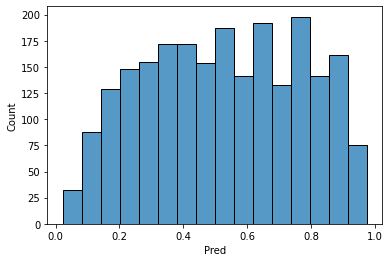

In [64]:
_ = sns.histplot(sub['Pred'])

In [65]:
sub.head()

,ID,Pred
0,2022_1103_1104,0.288677
1,2022_1103_1112,0.072389
2,2022_1103_1116,0.189079
3,2022_1103_1120,0.124575
4,2022_1103_1124,0.095755


Thanks for reading !